<a href="https://colab.research.google.com/github/ancastillar/Study-on-the-probability-of-payment-of-a-credit-requested-by-a-client/blob/main/EDA_LOAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Problem: You must answer the following question: "Should the company verify the income source of an online loan applicant before approving their loan?**


**Analytical Context.** The data is downloaded from [LendingClub (LC) Statistics](https://www.lendingclub.com/info/download-data.action) and it contains all loans issued from 2007 - 2012 along with their current loan status (fully paid or charged off). There are ~50 variables that describe the borrowers and the loans; for the sake of reducing complexity, the company has already performed a pre-screening of these variables based on existing analyses from LendingClub to select nine relevant variables, such as annual income, LendingClub credit grade, home ownership, etc. We will use, **logistic regression** and **random forest** to answer our question at hand.

**Instalation of some dependencies**

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

**Import Libraries**

In [20]:

import matplotlib.pyplot as plt
import numpy  as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from matplotlib.widgets import Slider, Button, RadioButtons
from IPython.display import display_html
import pandas as pd
from pandas_profiling import ProfileReport
plt.style.use('ggplot')

<h2>Data exploration</h2>
<p>Before we begin our exploratory analysis, let's take a look at the data at our disposal:</p>

First import the information:

In [33]:
df=pd.read_csv('/content/drive/MyDrive/data_davivienda/Lending_club.csv')

Let's take a look of a Profiling Report

In [5]:
profile = ProfileReport(df, title='Lending Club Dataset')
profile.to_file("/content/drive/MyDrive/data_davivienda/Lending_club.html")

In [6]:
profile

When do you regression is important to specify the categorical variables 

In [34]:
#Change loan_status, verification_status, emp_length, term and grade to category type 
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))
df.purpose = df.purpose.astype(pd.api.types.CategoricalDtype(categories=['debt_consolidation','credit_card','other','home_improvement','major_purchase','small_business','car', 'wedding','medical','moving','house','vacation','educational','renewable_energy']))

#In addition, the original data in int_rate contains strings of the form 'x.xx%',
#we remove the % and change the vaules to float:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')

Visualization of dataframe 

In [12]:
print("Dimension of Dataframe:", df.shape)
print(" ")
print("We have 38705 transactions some of these are fully paid or not. We can view this in the first column of a dataset. The variable annual_inc represents the person's income per year")
df.head()

Dimension of Dataframe: (38705, 10)
 
We have 38705 transactions some of these are fully paid or not. We can view this in the first column of a dataset. The variable annual_inc represents the person's income per year


,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B


Now let's explain each df variable in more detail:

<table>
<thead>
<tr>
<th align="center">annual_inc</th>
<th align="center">The self-reported annual income provided by the borrower during registration.</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">verification_status</td>
<td align="center">Indicates if income was verified by LC, not verified, or if the income source was verified</td>
</tr>
<tr>
<td align="center">emp_length</td>
<td align="center">Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</td>
</tr>
<tr>
<td align="center">home_ownership</td>
<td align="center">The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
</tr>
<tr>
<td align="center">int_rate</td>
<td align="center">Interest Rate on the loan</td>
</tr>
<tr>
<td align="center">loan_amnt</td>
<td align="center">The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</td>
</tr>
<tr>
<td align="center">purpose</td>
<td align="center">A category provided by the borrower for the loan request.</td>
</tr>
<tr>
<td align="center">term</td>
<td align="center">The number of payments on the loan. Values are in months and can be either 36 or 60.</td>
</tr>
<tr>
<td align="center">grade</td>
<td align="center">LC assigned loan grade, A: Goood client, G: Very risky</td>
</tr>
</tbody>
</table>

<h3>Relationships between <code>loan_status</code> and other variables</h3>

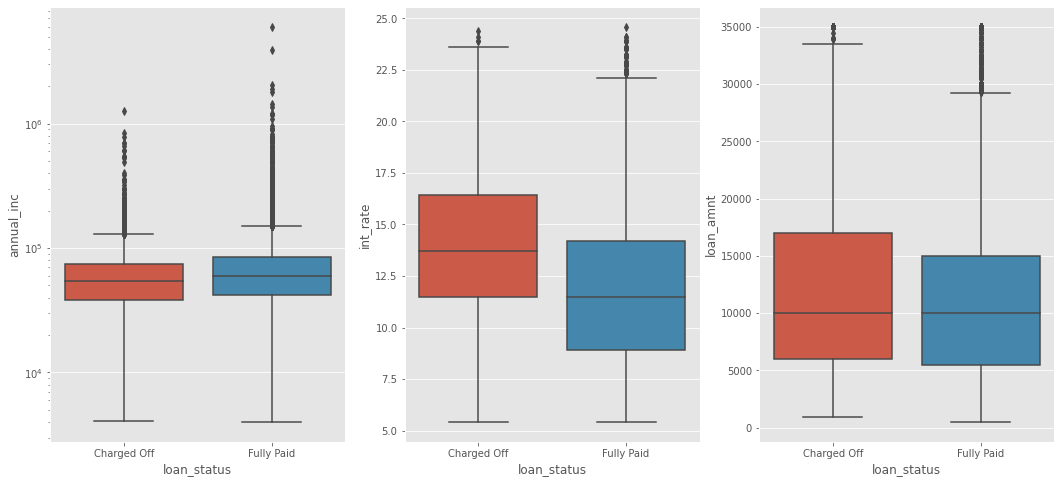

In [16]:
fig, ax=plt.subplots(1,3, figsize=(18,8))
sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='int_rate', x ='loan_status', data = df, ax=ax[1])
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[2]);

Statement: "From these plots we can conclude that annual income does not play a significant role in deciding if a user will or will not pay back his loan."

Do you think this statement is correct? How would you attempt to verify this?

To verify the above statement, we could use to calculate the p-value and see if there is enough statistical evidence to say that the two distributions have different means (concerning the annual_income variable). However, we should study a bit more in-depth and look for another way to answer our question. We are going to use the concept of **Contingency table**

In [17]:
def get_cngt(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res['Fully Paid(%)'] = round( ct_res['Fully Paid']/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')



For the variable verification_status we get:

In [19]:
get_cngt(df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


*This result reflects the Simpson paradox and for that reason, we must be careful with our conclusions, since this table does not take into account other possible factors that may affect users who pay their debts. For example, it may be the case that a significant portion of loans with smaller interest rates is made to unverified users, making it easier to repay the loan.*

<p> verify if the observed associations between <code>verification_status</code> and <code>loan_status</code> are statistically significant.</p>
For this we are going to use Chi-square,

In [21]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['verification_status'], columns=df['loan_status']))
print('verification_status: p-value for chi-square =', p)

verification_status: p-value for chi-square = 6.884998281535999e-17


The chi-square test verifies that the associations between `verfication_status` and `loan_status` are indeed statistically significant.

**Now, we must adjust for other variables to eliminate the possible effects of confusion. If we want to know if <code>verification_status</code> is really associated with loan_status as indicated in the contingency table above, we should consider stratifying the contingency table between <code>loan_status</code> and <code>verification_status</code> by other variables that are also associated with loan_status.**

In [23]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df.verification_status], columns = df.loan_status, margins = True)
    ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
    return ct_stra.drop(columns='All').drop('All', level=0)



In [24]:
get_ct_stra(df.home_ownership)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56

*We can conclude that the variable <code>home_ownership</code> is not related to the trend observed in the Simpson paradox*

Let's take a glance for variable <code>purpose</code>

In [26]:
get_ct_stra(df.purpose)

loan_status                             Charged Off  Fully Paid  Fully Paid (%)
purpose            verification_status                                         
car                Not Verified                  63         724           91.99
                   Source Verified               51         400           88.69
                   Verified                      41         220           84.29
credit_card        Not Verified                 191        2031           91.40
                   Source Verified              132        1049           88.82
                   Verified                     193        1411           87.97
debt_consolidation Not Verified                 917        6262           87.23
                   Source Verified              677        3866           85.10
                   Verified                    1109        5444           83.08
educational        Not Verified                  35         187           84.23
                   Source Verified                4          28           87.50
                   Verified                      13          50           79.37
home_improvement   Not Verified                 133        1050           88.76
                   Source Verified               91         631           87.40
                   Verified                     109         873           88.90
house              Not Verified                  24         113           82.48
                   Source Verified               18          80           81.63
                   Verified                      17         117           87.31
major_purchase     Not Verified                  90         924           91.12
                   Source Verified               65         526           89.00
                   Verified                      56         455           89.04
medical            Not Verified                  48         249           83.84
                   Source Verified               29         175           85.78
                   Verified                      24         145           85.80
moving             Not Verified                  33         202           85.96
                   Source Verified               40         156           79.59
                   Verified                      11         117           91.41
other              Not Verified                 298        1699           85.08
                   Source Verified              150         764           83.59
                   Verified                     152         775           83.60
renewable_energy   Not Verified                   8          24           75.00
                   Source Verified                4          33           89.19
                   Verified                       6          20           76.92
small_business     Not Verified                 157         495           75.92
                   Source Verified              109         340           75.72
                   Verified                     200         485           70.80
vacation           Not Verified                  23         141           85.98
                   Source Verified               15          93           86.11
                   Verified                      12          68           85.00
wedding            Not Verified                  30         348           92.06
                   Source Verified               28         265           90.44
                   Verified                      34         230           87.12

Let's take a glance for variable <code>term</code>

In [27]:
get_ct_stra(df.term)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

From the tables above we can conclude the following:
*  The difference in the probability of full payment between users  with verified and unverified income can be attributed to the effect of the loan <code>term</code> on the probability of full payment. Since it is observed in the <code>term</code> table the proportion of loans fully paid is stable concerning the verification status variable, however the result changes for loans with different payment terms. A similar behavior is observed in the variable <code>purpose</code>

*  The difference in the probability of full payment between users with verified and unverified income is not attributable to the effect of <code>home_ownership</code> on the probability of full payment. Due to no significant change in the proporcion of fully paid loans.

## Extracting additional information with linear regression

With the motivation to study a little more the result found with the chi-square test for the variables <code>loan_status</code> and <code>verfication_status</code>, we created a linear model that aims to explain loan_status using the variables given in our data set. 

In [35]:
df2=df.copy()

var_names=['loan_status','verification_status','grade','term','purpose']
for var in var_names:
    df2[var]=df2[var].cat.codes
    
var_names2=['annual_inc','int_rate','loan_amnt']
for var in var_names2:
    df2[var]=(df2[var]-df2[var].mean())/df2[var].std()

In [36]:
df2.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,1,-0.710290,2,10+ years,RENT,-0.378954,-0.843862,1,0,1
1,0,-0.616866,1,< 1 year,RENT,0.863143,-1.178519,6,1,2
2,1,-0.893213,0,10+ years,RENT,1.048651,-1.191906,5,0,2
3,1,-0.317912,1,10+ years,RENT,0.384586,-0.174546,2,0,2
4,1,0.161661,1,1 year,RENT,0.169505,-1.111588,2,1,1


Let's consider a simple model using the variables <code>annual_inc</code>, <code>verification_status</code>, <code>loan_amnt</code>, <code>int_rate</code> ,<code>term</code> and <code>purpose</code>:

In [37]:
model_lineal = 'loan_status~verification_status+annual_inc+loan_amnt+int_rate+term+purpose'
lm_lineal   = sfm.ols(formula = model_lineal, data = df2).fit()
print(lm_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     323.8
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        03:53:21   Log-Likelihood:                -13067.
No. Observations:               38705   AIC:                         2.615e+04
Df Residuals:                   38698   BIC:                         2.621e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8808    